# Resonant Cancellation

## Imports and Definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from glob import glob
from scipy.optimize import curve_fit
from scipy.constants import physical_constants

from helperFunctions import *

In [2]:
# plot settings, increase font sizes
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.labelspacing'] = 0.2

## Polarization Measurement

In [3]:
N_up = 150167
N_dn = 10690

print('flipping-ratio:\t {:.1f}'.format(N_up/N_dn))
print('polarization:\t {:.0f}%'.format(100*(N_up-N_dn)/(N_up+N_dn)))

flipping-ratio:	 14.0
polarization:	 87%


## Rabi Measurements

### Frequency Scans

resonance SF 1: (91.94 +/- 0.01) kHz
resonance SF 2: (91.46 +/- 0.01) kHz


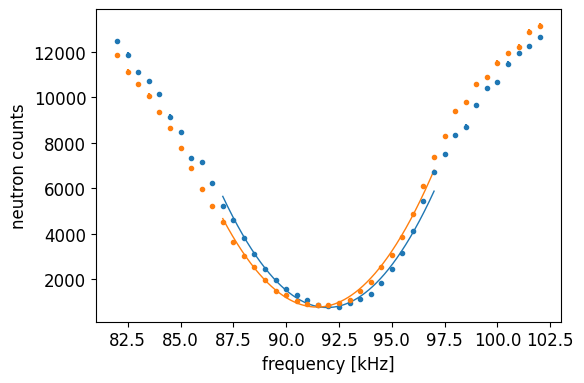

In [4]:
fig, ax = plt.subplots()

######################
# SF 1
######################

# get the data from the files
files = sorted(glob("data/rabi_freq_SF1/*.dat"))
frq = np.zeros(len(files))
det = np.zeros(len(files))
for i,file in enumerate(files):
    frq[i] = int(file[-34:-28])
    with open(file, 'r') as fp:
        det[i] = int(fp.readlines()[4].split()[0])

# fit a qudratic function around the minimum
popt,pcov = np.polyfit(frq[10:-10], det[10:-10], 2, w=1/np.sqrt(det[10:-10]), cov='unscaled')
perr = np.sqrt(np.diag(pcov))

# calculate the frequency at the minimum
res = np.array([-popt[1]/2/popt[0], np.sqrt(perr[1]**2/4/popt[0]**2 + popt[1]**2*perr[0]**2/4/popt[0]**4 - popt[1]*pcov[0,1]/2/popt[0]**3)])
print('resonance SF 1: ({:.2f} +/- {:.2f}) kHz'.format(*res/1e3))

# plot the data and the fit
xFit = np.linspace(frq[10:-10].min(), frq[10:-10].max(), 1000)
yFit = np.polyval(popt, xFit)
ax.errorbar(frq/1e3, det, np.sqrt(det), fmt='C0.')
ax.plot(xFit/1e3, yFit, 'C0-', lw=1)


######################
# SF 2
######################

# get the data from the files
files = sorted(glob("data/rabi_freq_SF2/*.dat"))
frq = np.zeros(len(files))
det = np.zeros(len(files))
for i,file in enumerate(files):
    frq[i] = int(file[-34:-28])
    with open(file, 'r') as fp:
        det[i] = int(fp.readlines()[4].split()[0])

# fit a qudratic function around the minimum
popt,pcov = np.polyfit(frq[10:-10], det[10:-10], 2, w=1/np.sqrt(det[10:-10]), cov='unscaled')
perr = np.sqrt(np.diag(pcov))

# calculate the frequency at the minimum
res = np.array([-popt[1]/2/popt[0], np.sqrt(perr[1]**2/4/popt[0]**2 + popt[1]**2*perr[0]**2/4/popt[0]**4 - popt[1]*pcov[0,1]/2/popt[0]**3)])
print('resonance SF 2: ({:.2f} +/- {:.2f}) kHz'.format(*res/1e3))

# plot the data and the fit
xFit = np.linspace(frq[10:-10].min(), frq[10:-10].max(), 1000)
yFit = np.polyval(popt, xFit)
ax.errorbar(frq/1e3, det, np.sqrt(det), fmt='C1.')
ax.plot(xFit/1e3, yFit, 'C1-', lw=1)

ax.set(xlabel='frequency [kHz]', ylabel='neutron counts')
fig.set(dpi=100)
fig.tight_layout()
plt.show()

## Ramsey Measurements

### Frequency Scan

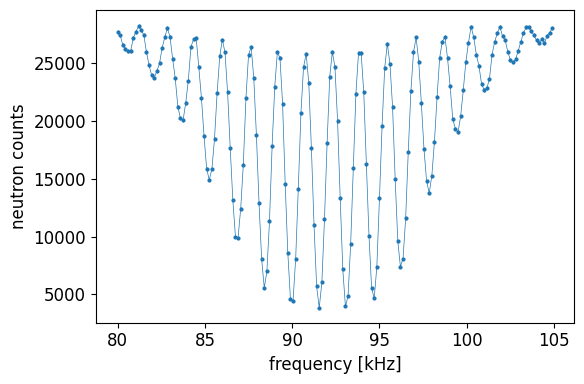

In [5]:
# get the data from the files
files = sorted(glob("data/ramsey_freq_full/*.dat"))
frq = np.zeros(len(files))
det = np.zeros(len(files))
for i,file in enumerate(files):        
    frq[i] = int(file[-44:-38])    
    with open(file, 'r') as fp:
        det[i] = int(fp.readlines()[4].split()[0])

# plot the data
fig, ax = plt.subplots()
ax.errorbar(frq[:-14]/1e3, det[:-14], np.sqrt(det[:-14]), fmt='C0.-', ms=4, lw=0.5, elinewidth=0.5)
ax.set(xlabel='frequency [kHz]', ylabel='neutron counts')
fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/ramseyFrequencyScan.png', transparent=True, dpi=200, bbox_inches="tight")
plt.show()

In [6]:
vis = (det.max()-det.min()) / (det.max()+det.min())
print('visibility:\t {:.0f}%'.format(100*vis))

visibility:	 76%


(-1.096 +/- 0.002) kHz/A
-38 uT/A


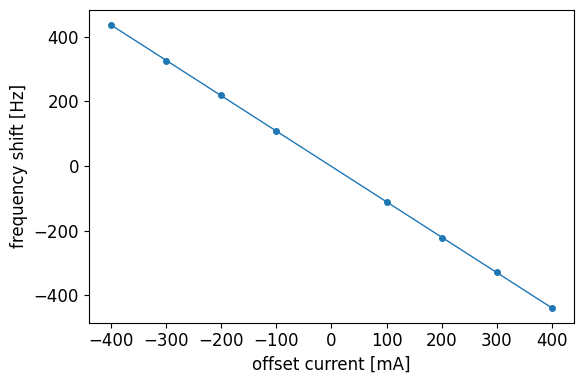

In [7]:
DC = ['p000', 'n200', 'n150', 'n100', 'n050', 'p050', 'p100', 'p150', 'p200']

dcNum = np.zeros(len(DC))
fMax = np.zeros((2,len(DC)))
for j,dc in enumerate(DC):

    # get the data from the files
    files = sorted(glob("data/ramsey_freq_DC{}mV/ramsey_*.dat".format(dc)))
    frq = np.zeros(len(files))
    det = np.zeros(len(files))
    for i,file in enumerate(files):
        frq[i] = int(file[-44:-38])
        with open(file, 'r') as fp:
            det[i] = int(fp.readlines()[5].split()[0])

    # shift the data to zero, because we are only interested in the shift
    frq -= frq.mean()

    # fit the data with a sinusoidal
    popt = (1/1600,-100,10000,15000)
    popt, pcov = curve_fit(sinFrqFct, frq, det, sigma=np.sqrt(det), absolute_sigma=True, p0=popt)
    perr = np.sqrt(np.diag(pcov))
    fMax[:,j] = popt[1], perr[1]
    dcNum[j] = int(dc[1:]) if dc[0]=='p' else -int(dc[1:])

# convert the applied voltage into a current
current = 2*dcNum[1:]

# subtract the frequency of the reference 
fMax = fMax[0,1:]-fMax[0,0], np.sqrt(fMax[1,1:]**2 + fMax[1,0]**2)

# perform a linear fit
popt, pcov = np.polyfit(current, fMax[0], 1, w=1/fMax[1], cov='unscaled')
perr = np.sqrt(np.diag(pcov))
freqChange = popt[0], perr[0]
print('({:.3f} +/- {:.3f}) kHz/A'.format(*freqChange))
print('{:.0f} uT/A'.format(freqChange[0]/(gamma_n/2/np.pi)*1e9))

# plot the data
fig, ax = plt.subplots()
ax.errorbar(current, fMax[0], fMax[1], fmt='C0o', ms=4)
ax.plot(current, np.polyval(popt, current), '-', lw=1)
ax.set(xlabel='offset current [mA]', ylabel='frequency shift [Hz]')
fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/ramseyFrequencyShiftSlope.png', transparent=True, dpi=200, bbox_inches="tight")
plt.show()

### Phase Scan

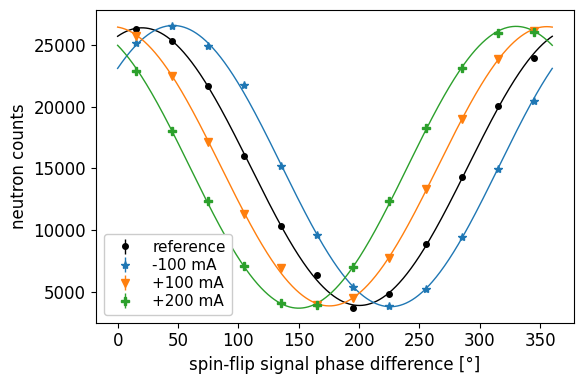

In [8]:
# define the data sets and plot options
DC = np.array(['-0', '-50', '+50', '+100'])
marker = ['o', '*', 'v', 'P']
phsFit = np.linspace(0, 360, 1001)

fig, ax = plt.subplots()

for j,dc in enumerate(DC):

    # get the data from the files
    files = sorted(glob("data/ramsey_phase_DC{}mV/ramsey_*.dat".format(dc)))
    phs = np.zeros(len(files))
    det = np.zeros(len(files))
    for i,file in enumerate(files):
        phs[i] = int(file[-22:-19])
        with open(file, 'r') as fp:
            det[i] = int(fp.readlines()[4].split()[0])

    # fit the sinusoidal function with fixed period
    popt, pcov = curve_fit(sinPhaseFct, phs, det, sigma=np.sqrt(det), absolute_sigma=True, p0=(10000, -90, 10000))
    perr = np.sqrt(np.diag(pcov))

    # plot the data and the fit
    if dc=='-0':
        ax.errorbar(phs, det, np.sqrt(det), fmt='k{}'.format(marker[j]), ms=4, lw=1, label='reference')
        ax.plot(phsFit, sinPhaseFct(phsFit, *popt), 'k-', lw=1)
    else:
        ax.errorbar(phs, det, np.sqrt(det), fmt='{}'.format(marker[j]), ms=6, lw=1, c='C{}'.format(j-1), label='{:+d} mA'.format(2*int(dc)))
        ax.plot(phsFit, sinPhaseFct(phsFit, *popt), '-', lw=1, c='C{}'.format(j-1))

# change plot settings
ax.legend(loc='lower left', framealpha=1)
ax.set(xlabel='spin-flip signal phase difference [°]', ylabel='neutron counts')
fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/ramseyPhaseShift.png', transparent=True, dpi=200, bbox_inches="tight")
plt.show()

(-257.0 +/- 0.4) deg/A


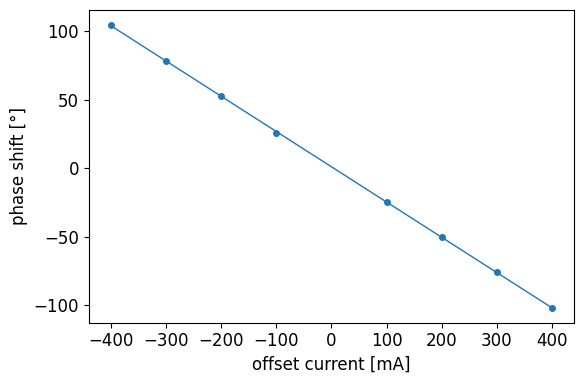

In [9]:
# process all phase scans
DC_mV = np.array(['-0', '-200', '-150', '-100', '-50', '+50', '+100', '+150', '+200'])
phase = np.zeros((2,len(DC_mV)))
for j,dc in enumerate(DC_mV):

    # get the data from the files
    files = sorted(glob("data/ramsey_phase_DC{}mV/ramsey_*.dat".format(dc)))
    phs = np.zeros(len(files))
    det = np.zeros(len(files))
    for i,file in enumerate(files):
        phs[i] = int(file[-22:-19])
        with open(file, 'r') as fp:
            det[i] = int(fp.readlines()[4].split()[0])

    # fit the sinusoidal phase function
    popt, pcov = curve_fit(sinPhaseFct, phs, det, sigma=np.sqrt(det), absolute_sigma=True, p0=(10000, -90, 10000))
    perr = np.sqrt(np.diag(pcov))
    phase[:,j] = popt[1], perr[1]

# convert the applied voltage into a current
current = 2*DC_mV[1:].astype(int)

# subtract the phase of the reference 
phase = phase[0,1:]-phase[0,0], np.sqrt(phase[1,1:]**2 + phase[1,0]**2)

# perform a linear fit
popt, pcov = np.polyfit(current, phase[0], 1, w=1/phase[1], cov='unscaled')
perr = np.sqrt(np.diag(pcov))
phaseChange = popt[0], perr[0]
print('({:.1f} +/- {:.1f}) deg/A'.format(1e3*phaseChange[0], 1e3*phaseChange[1]))

# plot the data
fig, ax = plt.subplots()
ax.errorbar(current, phase[0], phase[1], fmt='C0o', ms=4)
ax.plot(current, np.polyval(popt, current), '-', lw=1)
ax.set(xlabel='offset current [mA]', ylabel='phase shift [°]')
fig.set(dpi=100)
fig.tight_layout()
plt.show()

### Interaction Length Estimation

In [10]:
# calculate the interaction length from the two Ramsey measurements
L = v_n * phaseChange[0] / 360 / freqChange[0]
LErr = np.sqrt((v_n/360/freqChange[0])**2 * phaseChange[1]**2 
               + (v_n*phaseChange[0]/360/freqChange[0]**2)**2 * freqChange[1]**2)

print('interaction length: ({:.1f} +/- {:.1f}) cm'.format(1e2*L, 1e2*LErr))

interaction length: (51.9 +/- 0.1) cm


## Resonant Cancellation

### Example Signals

In [11]:
# get the array with the measured frequencies
files = sorted(glob("data/axion_fineScan_1/faxion_*_1.dat"))
frq = np.zeros(len(files))
for i,file in enumerate(files):
    frq[i] = int(file[-35:-31])
    
    # get the time bin size from the first file
    if i==0:
        with open(file, 'r') as fp:
            tBin = int(fp.readlines()[1].split()[4]) / 1e6      

f:	252 Hz
a:	37 +/- 1
o:	368 +/- 1
a/o:	0.100 +/- 0.004
X²/NDF:	329/391

f:	1020 Hz
a:	59 +/- 6
o:	1463 +/- 4
a/o:	0.040 +/- 0.004
X²/NDF:	92/93

f:	1477 Hz
a:	5 +/- 8
o:	2093 +/- 6
a/o:	0.003 +/- 0.004
X²/NDF:	52/62

f:	2227 Hz
a:	67 +/- 12
o:	3108 +/- 9
a/o:	0.022 +/- 0.004
X²/NDF:	47/39



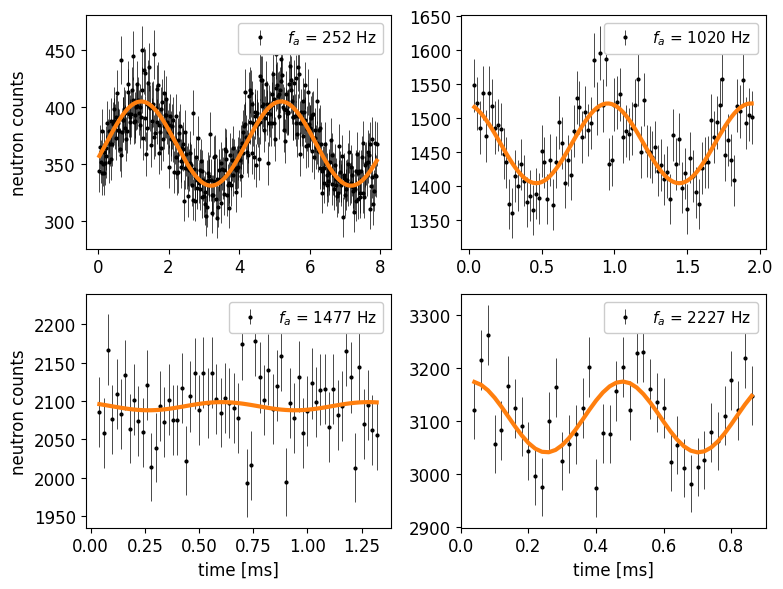

In [12]:
# chose four frequencies to plot (closest one will be chosen)
freqs = [250, 1000, 1500, 2200]
    
fig, ax = plt.subplots(2,2, figsize=(8,6))

for i,freq in enumerate(freqs):

    # find the closest frequency index
    frqIdx = np.argmin(abs(frq - freq))
    file = files[frqIdx]

    # load the data from the file
    data = np.loadtxt(file, skiprows=5)
    time = np.arange(len(data)) * tBin
    
    # remove the empty bins and
    # remove the first and last two filled time bins
    # they may contain wrong numbers due to the phasing/mapping
    mask = data!=0
    time = time[mask][2:-2]
    data = data[mask][2:-2]

    # calculate the Poisson error
    error = np.sqrt(data)

    # fit the data with a sinusoidal function
    popt = (0.5*(data.max()-data.min()), -90, data.mean())
    popt, pcov = curve_fit(lambda t,a,p,o:sinFct(t,frq[frqIdx],a,p,o), time, data, 
                           sigma=error, absolute_sigma=True, p0=popt)
    perr = np.sqrt(np.diag(pcov))
    chi2 = np.sum((sinFct(time,frq[frqIdx],*popt)-data)**2 / error**2)
    NDF = len(time)-len(popt)

    # calculate the ratio of the amplitude and the offset
    amp = ratio([abs(popt[0]),perr[0]], [popt[-1],perr[-1]])

    # print the results
    print('f:\t{:.0f} Hz'.format(frq[frqIdx]))
    print('a:\t{:.0f} +/- {:.0f}'.format(abs(popt[0]), perr[0]))
    print('o:\t{:.0f} +/- {:.0f}'.format(popt[-1], perr[-1]))
    print('a/o:\t{:.3f} +/- {:.3f}'.format(*amp))
    print('X²/NDF:\t{:.0f}/{:.0f}\n'.format(chi2,NDF))

    # plot the data
    ax[i>>1,i%2].errorbar(1e3*time, data, error, fmt='k.', ms=4, lw=0.5, label='$f_a$ = {:.0f} Hz'.format(frq[frqIdx]))
    ax[i>>1,i%2].plot(1e3*time, sinFct(time, frq[frqIdx], *popt), 'C1-', lw=3, zorder=9)
    ax[i>>1,i%2].legend(loc='upper right', framealpha=1)

# change the plot settings
ax[0,0].set(ylabel='neutron counts')
ax[1,0].set(xlabel='time [ms]', ylabel='neutron counts')
ax[1,1].set(xlabel='time [ms]')
fig.align_xlabels()
fig.align_ylabels()
fig.set(dpi=100)
fig.tight_layout()
fig.savefig('plots/neutronSignals.png', transparent=True, dpi=200, bbox_inches="tight")
plt.show()

### Fluxgate Normalization

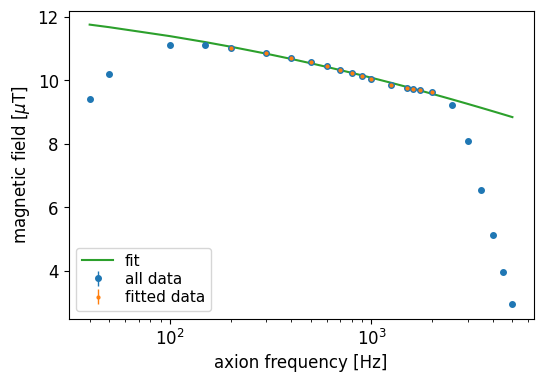

In [13]:
# load the data from the file
frq_fg = np.load('data/axion_magneticField_scan4.npz')['Frq']
sig_fg = np.load('data/axion_magneticField_scan4.npz')['Sig']

# lowest frequency to consider (no reasonable function below 200 Hz)
idx_min = np.argmin(abs(frq_fg-200))
# highest frequency to consider (FG response constant up to 2 kHz)
idx_max = np.argmin(abs(frq_fg-2000))+1

# fit the fluxgate data with a filter function in the reasonable range
popt_mag,_ = curve_fit(butterworthFct, frq_fg[idx_min:idx_max], sig_fg[0,idx_min:idx_max,0])

# plot the data
fig, ax = plt.subplots()
ax.errorbar(frq_fg, sig_fg[0,:,0], sig_fg[0,:,1], fmt='.', ms=8, lw=1, label='all data')
ax.errorbar(frq_fg[idx_min:idx_max], sig_fg[0,idx_min:idx_max,0], sig_fg[0,idx_min:idx_max,1], fmt='.', ms=4, lw=1, label='fitted data')
ax.plot(frq_fg[:], butterworthFct(frq_fg[:], *popt_mag), '-', label='fit')
ax.legend(loc='lower left')
ax.set(xlabel='axion frequency [Hz]', ylabel='magnetic field [$\mu$T]', xscale='log', yscale='linear')
fig.set(dpi=100)
plt.show()

# convert to relative normalization of the fluxgate instead of absolute field values
popt_mag[0] = 1

# calculate the normalization for the tested frequencies
norm_mag = butterworthFct(frq, *popt_mag)

In [14]:
dec = (butterworthFct(200, *popt_mag) - butterworthFct(2000, *popt_mag)) / butterworthFct(200, *popt_mag)
print('decrease from 200 Hz to 2 kHz: {:.0f} %'.format(100*dec))

decrease from 200 Hz to 2 kHz: 13 %


### Cancellation

In [15]:
# process the data from the three data sets
iterations = np.arange(3)
sig = np.zeros((len(frq), len(iterations), 2))
for it in iterations:

    # load the data from the file
    files = sorted(glob("data/axion_fineScan_1/faxion_*_{}.dat".format(it+1)))
    for i,file in enumerate(files):
        data = np.loadtxt(file, skiprows=5)
        time = np.arange(len(data)) * tBin

        # remove the empty bins and
        # remove the first and last two filled time bins
        # they may contain wrong numbers due to the phasing/mapping
        mask = data!=0
        time = time[mask][2:-2]
        data = data[mask][2:-2]

        # calculate the Poisson error
        error = np.sqrt(data)

        # fit the data with a sinusoidal function
        if i==0:
            popt = (0.5*(data.max()-data.min()), -90, data.mean())
        popt, pcov = curve_fit(lambda t,a,p,o: sinFct(t,frq[i],a,p,o), time, data, sigma=error, absolute_sigma=True, p0=popt)
        perr = np.sqrt(np.diag(pcov))

        # calculate the ratio of the amplitude and the offset
        amp = ratio([abs(popt[0]),perr[0]], [popt[-1],perr[-1]])
        sig[i,it,:] = amp

# average the three data sets
sig_tot = np.asarray([weighted_mean(sig[i,:,0], sig[i,:,1]) for i in range(len(frq))]).T

# normalize the neutron data with the fluxgate data for the same frequency range
idx_norm = np.argmin(abs(frq-200))
sig_tot[:,idx_norm:] /= norm_mag[idx_norm:]/norm_mag[idx_norm]

first root at:			(1529 +/- 7) Hz
second root at:			(3057 +/- 14) Hz
effective interaction length:	0.522 +/- 0.002 m

reduced Chi2:			1.04
NDF:				98
pull mean / width:		-0.04 / 1.01



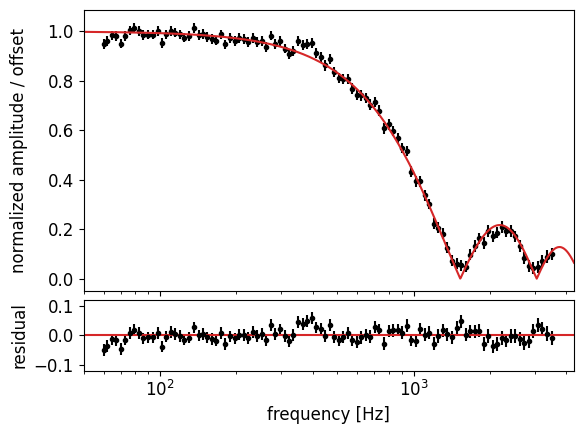

In [16]:
# fit the resonant cancelation function
popt, pcov = curve_fit(resonantCancelation, frq, sig_tot[0], sigma=sig_tot[1], absolute_sigma=True, p0=(0.1, 1e-3))
perr = np.sqrt(np.diag(pcov))

# calculate and print the values of the roots and the effective length
root = np.array([1/popt[1], perr[1]/popt[1]**2])
print('first root at:\t\t\t({:.0f} +/- {:.0f}) Hz'.format(*1*root))
print('second root at:\t\t\t({:.0f} +/- {:.0f}) Hz'.format(*2*root))
print('effective interaction length:\t{:.3f} +/- {:.3f} m\n'.format(v_n*popt[1], v_n*perr[1])) 

# calculate the chi2 and the pull distribution
chi2 = np.sum((resonantCancelation(frq,*popt)-sig_tot[0])**2 / sig_tot[1]**2)
chi2_red = chi2/(len(frq)-len(popt)), np.sqrt(2/(len(frq) - len(popt)))
pull_dist = (resonantCancelation(frq,*popt)-sig_tot[0]) / sig_tot[1]
print('reduced Chi2:\t\t\t{:.2f}'.format(chi2_red[0]))
print('NDF:\t\t\t\t{:.0f}'.format(len(frq)-len(popt)))
print('pull mean / width:\t\t{:.2f} / {:.2f}\n'.format(pull_dist.mean(), pull_dist.std()))

# normalize the data to one at DC
norm = resonantCancelation(0.001, *popt)
sig_tot /= norm

# create the fitted data
fFit = np.logspace(np.log10(50), np.log10(4290), 1001)
yFit = resonantCancelation(fFit, *popt)/norm

# create the residuals
residuals = (sig_tot[0]-resonantCancelation(frq, *popt)/norm), sig_tot[1]

# plot the data, the fit, and the residuals
fig, ax = plt.subplots(2,1,sharex=True,figsize=(6,4.5),gridspec_kw={'height_ratios':[4,1]})
ax[0].errorbar(frq, *sig_tot, fmt='k.', zorder=1)
ax[0].plot(fFit, yFit, 'C3-', lw=1.5)
ax[0].set(ylabel='normalized amplitude / offset', xscale='log', xlim=(fFit.min(),fFit.max()))
ax[1].errorbar(frq, *residuals, fmt='k.')
ax[1].axhline(0, c='C3', ls='-', lw=1.5)
ax[1].set(xlabel='frequency [Hz]',  ylabel='residual', ylim=(-0.12,0.12))
fig.set(dpi=100)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)
fig.align_ylabels(ax)
fig.savefig('plots/resonantCancellation.png', transparent=True, dpi=200, bbox_inches="tight")
plt.show()